# Analyse de signal 1 (fenêtre réduite)

## Importation des librairies nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import STL, MSTL, seasonal_decompose

# Preparation des données

## Importation

In [2]:
data_real = pd.read_csv('./data1.csv', sep=";")

## Affichage

In [3]:
data = data_real.iloc[:, [0, 1, 6]].to_numpy()
time_serie = pd.Series(data[:, 2], dtype='float64')
time_serie = time_serie.dropna()

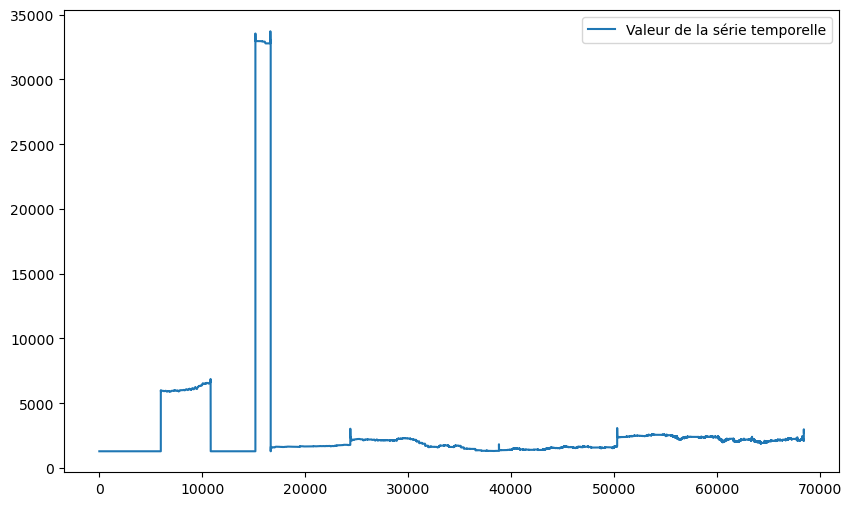

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(time_serie, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On observe que les données sont corrompues.

Sur le début de la plage de données, on observe des paliers de valeurs, celles si ne varient pas ou peu et sont subitement projetées sur d'autres valeurs:

1) entre 0 et 10 000 on a un pic qui passe de 1 280 à environ 6 500
2) entre 15 000 et 20 000 on a un pic qui passe de 1 280 à 32 770

Un nettoyage des données se présente comme nécéssaire 

# Nettoyage des données

On sélectionne seulement la partie du signal qui nous intéresse

Dates des relevés de la série 1 :  2021.08.05 16:20  -  2021.08.31 23:55
Nombre de données séries 1 :  7580


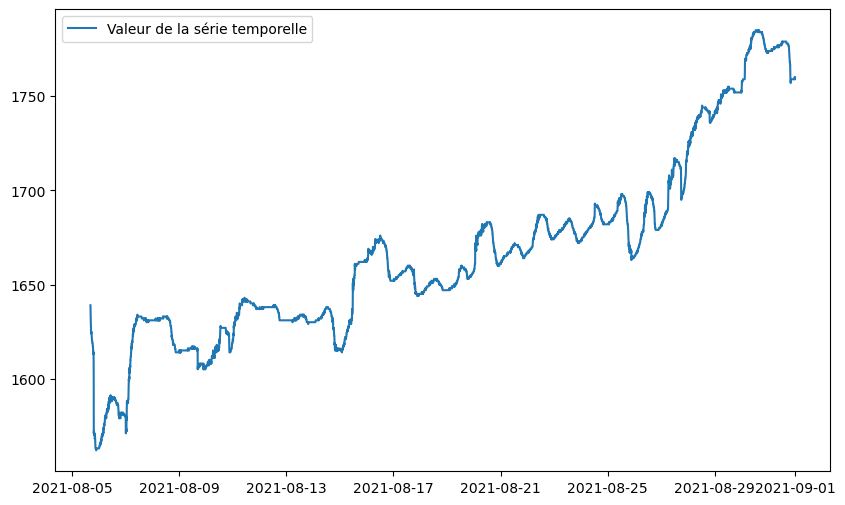

In [9]:
# D'après la base de donnée on obtient cet indice
data_crop = data[16656:24236,:] 

# Transformation en série temporelle
time_serie_crop = pd.Series(data_crop[:,2], dtype='float64')

# Création de l'axe des abscisses (dates)
data_time = data_crop[:, 1] 
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]

# Vérification de la fenêtre d'observation
print("Dates des relevés de la série 1 : ", data_crop[0,1], " - ", data_crop[-1,1])
print("Nombre de données séries 1 : ", len(data_crop[:,1]))

# Affichage de la série
plt.figure(figsize=(10, 6))
plt.plot(datetime_data,time_serie_crop, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On regarde quel est le pas de temps entre chaque prise de données

In [11]:
data_time = data_real.iloc[16656:24236, 1].to_numpy()
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]

# Calcul des différences en minutes
differences_minutes = [
    (datetime_data[i] - datetime_data[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data))
]

# Affichage des résultats
print("Différences en minutes entre chaque données :")
print(np.unique(differences_minutes))

Différences en minutes entre chaque données :
[5.]


## Detection des discontinuités

In [13]:
def detect_pic(data, seuil=100):
    pic_indices = []
    offset_indices = []
    
    # Parcours des valeurs de la série
    for i in range(1, len(data) - 2):
        
        # on regarde si la différence entre les 2 valeurs est plus grande en valeur absolue que le seuil
        if np.abs(data[i] - data[i+1]) >= seuil :
            # si le saut suivant est aussi supérieur à un pic alors ceci est une valeur aberrante
            if np.abs(data[i+1] - data[i+2]) >= seuil : 
                pic_indices.append(i+1) 
            # sinon on considère qu'il y a un problème d'offset
            else : 
                offset_indices.append(i+1) 
        
    return pic_indices, offset_indices

In [15]:
pic, offset = detect_pic(data_crop[:,2])

print("Nombre de pics détectés :", len(pic))
print("Nombre d'offset détectés :", len(offset))
print("Indices des pics :", pic)
print("Indices des offset :", offset)
print("Valeurs des pics :", data_crop[pic])

Nombre de pics détectés : 0
Nombre d'offset détectés : 0
Indices des pics : []
Indices des offset : []
Valeurs des pics : []


# Décomposition spéctrale

## Transformée de Fourier

rfft calcule la FFT pour un signal réel, ce qui est plus efficace et donne un résultat simplifié. La FFT transforme le signal data_ajust (une série temporelle) en une série de composantes fréquentielles, exprimées sous forme de nombres complexes.
np.real : Prend la partie réelle de la FFT, ce qui correspond aux amplitudes des composantes fréquentielles, en éliminant la partie imaginaire.

Dans le graphe, on prend la première moitié des fréquences et des amplitudes, car la seconde moitié (au-delà de la fréquence de Nyquist) est symétrique et n'apporte pas d'information nouvelle pour un signal réel.

In [17]:
data_ajust = data_crop[:,2]

In [19]:
# Fonction pour passer d'une échelle de Hz à jours
def freq_to_day (freq) :
    return (1/freq)/(60*24*24)

### Calcul de la FFT

Période ayant la plus grande amplitude 2.2689176245210727 j


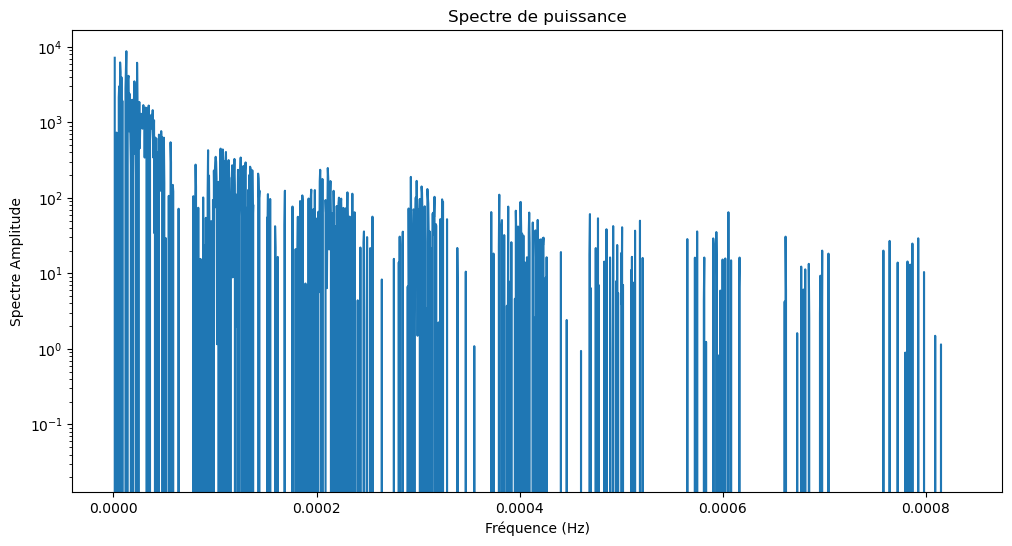

In [21]:
# Les deux premières fréquences/amplitudes sont anormales
# 1 mesure toutes les 5 min
signal_fft = np.fft.rfft(data_ajust)
amplitudes = np.real(signal_fft)[3:] 
frequencies = np.fft.rfftfreq(len(data_ajust),5*60)[3:] 

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2], label='Spectre original')

# Affichage du spectre 
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
print("Période ayant la plus grande amplitude", freq_to_day(frequencies[np.argmax(amplitudes)]),"j" )

On observe sur ce signal que :
- La fréquence correspondante au cycle diurne n'est pas captée
- Nous n'avons pas une fréquence et des harmoniques mais des agglomérats autour des fréquences de références

Nous allons donc moyenner les fréquences pour obtenir qu'une seule fréquence par agglomérat

### Harmoniques : Moyennes par agglomérat

In [23]:
def average_by_chunk(frequencies, amplitudes, chunk_size=50):
    # Calcul du nombre de blocs
    num_chunks = len(frequencies) // chunk_size
    avg_frequencies = []
    avg_amplitudes = []
    
    # Diviser en blocs et calculer la moyenne
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        # Sélectionner les indices du bloc
        chunk_frequencies = frequencies[start_idx:end_idx]
        chunk_amplitudes = amplitudes[start_idx:end_idx]
        
        # Calculer la fréquence moyenne (c'est la fréquence du centre du bloc)
        avg_frequency = np.mean(chunk_frequencies)
        
        # Calculer l'amplitude moyenne du bloc
        avg_amplitude = np.mean(chunk_amplitudes)
        
        avg_frequencies.append(avg_frequency)
        avg_amplitudes.append(avg_amplitude)
    
    return np.array(avg_frequencies), np.array(avg_amplitudes)


Période ayant la plus grande amplitude 1.3852339181286548 j avec chunk = 90
Période ayant la plus grande amplitude 1.0527777777777778 j avec chunk = 120


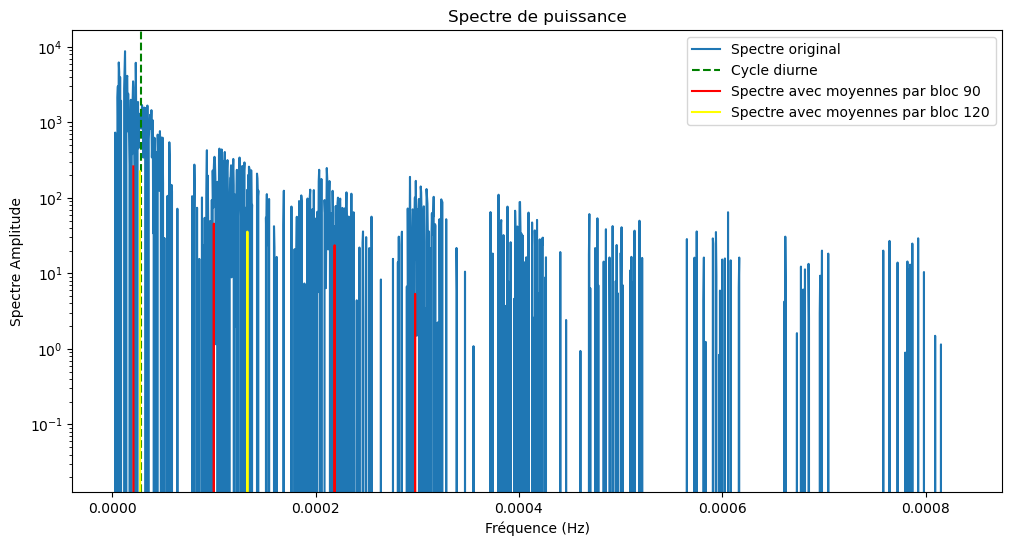

In [25]:
plt.figure(figsize=(12, 6))
plt.semilogy((frequencies[3:len(frequencies)//2]), amplitudes[3:len(amplitudes)//2], label='Spectre original')
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Cycle diurne')

chunk_size = 90
frequencies_avg_90, amplitudes_avg_90 = average_by_chunk(frequencies, amplitudes, chunk_size)
plt.semilogy(frequencies_avg_90[:len(frequencies_avg_90)//2], amplitudes_avg_90[:len(frequencies_avg_90)//2],  label='Spectre avec moyennes par bloc 90', color='red')
print("Période ayant la plus grande amplitude", freq_to_day(frequencies_avg_90[np.argmax(amplitudes_avg_90)]),"j avec chunk =", chunk_size )

chunk_size = 120
frequencies_avg_120, amplitudes_avg_120 = average_by_chunk(frequencies, amplitudes, chunk_size)
plt.semilogy(frequencies_avg_120[:len(frequencies_avg_120)//2], amplitudes_avg_120[:len(frequencies_avg_120)//2],  label='Spectre avec moyennes par bloc 120', color='yellow')
print("Période ayant la plus grande amplitude", freq_to_day(frequencies_avg_120[np.argmax(amplitudes_avg_120)]),"j avec chunk =", chunk_size )

# Affichage du spectre avec les amplitudes moyennes par bloc
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
plt.legend()


Le résutlat proposé est beaucoup plus pertinent mais n'est toujours pas très robuste car il dépend énormément de la taille de chunk que nous proposons

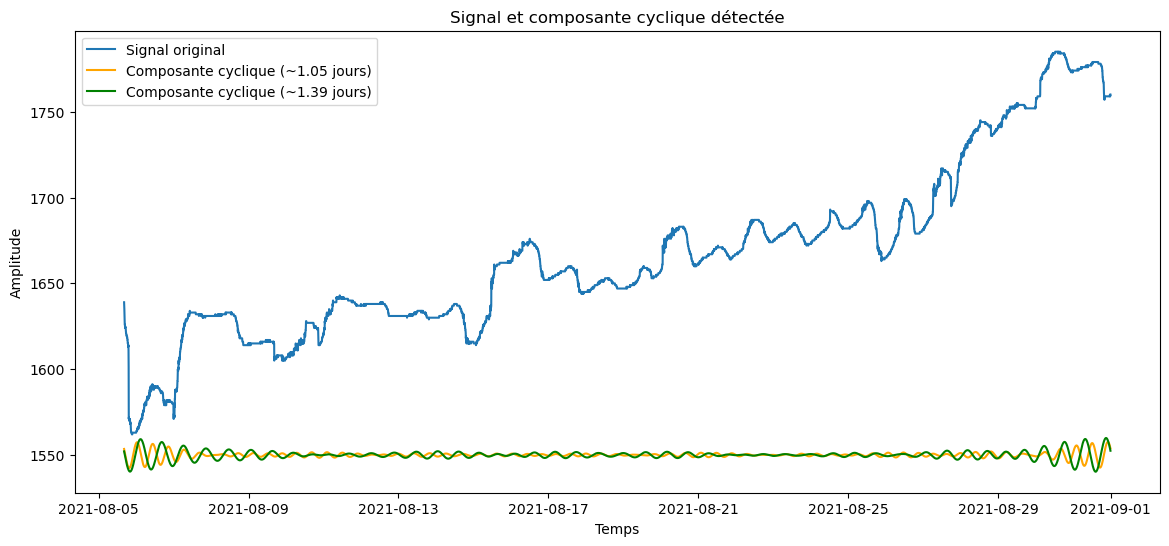

In [27]:
# Paramètres
T = 5*60  # Un point toutes les 5 min d'où 5*60
fs = 1 / T  
N = len(data_ajust) # Nombre de points
frequence_principale_120 = frequencies_avg_120[np.argmax(amplitudes_avg_120)]
frequence_principale_90 = frequencies_avg_90[np.argmax(amplitudes_avg_90)]

# Filtrage autour de la fréquence dominante
largeur_bande_120 = frequence_principale_120 / 10  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
filtre_cyclique_120 = (np.abs(np.fft.rfftfreq(N, T) - frequence_principale_120) < largeur_bande_120)
largeur_bande_90 = frequence_principale_90 / 10  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
filtre_cyclique_90 = (np.abs(np.fft.rfftfreq(N, T) - frequence_principale_90) < largeur_bande_90)

# Appliquer le filtre pour isoler la composante cyclique
signal_cyclique_fft_120 = signal_fft * filtre_cyclique_120
signal_cyclique_120 = np.fft.irfft(signal_cyclique_fft_120)
signal_cyclique_fft_90 = signal_fft * filtre_cyclique_90
signal_cyclique_90 = np.fft.irfft(signal_cyclique_fft_90)

# Affichage du signal original et de sa composante cyclique
plt.figure(figsize=(14, 6))
plt.plot(datetime_data,data_ajust, label="Signal original")
plt.plot(datetime_data,signal_cyclique_120.real+1550, label=f"Composante cyclique (~{freq_to_day(frequence_principale_120):.2f} jours)", color="orange")
plt.plot(datetime_data,signal_cyclique_90.real+1550, label=f"Composante cyclique (~{freq_to_day(frequence_principale_90):.2f} jours)", color="green")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

### Harmoniques : Détection par peaks

Période ayant la plus grande amplitude 2.2689176245210727 j


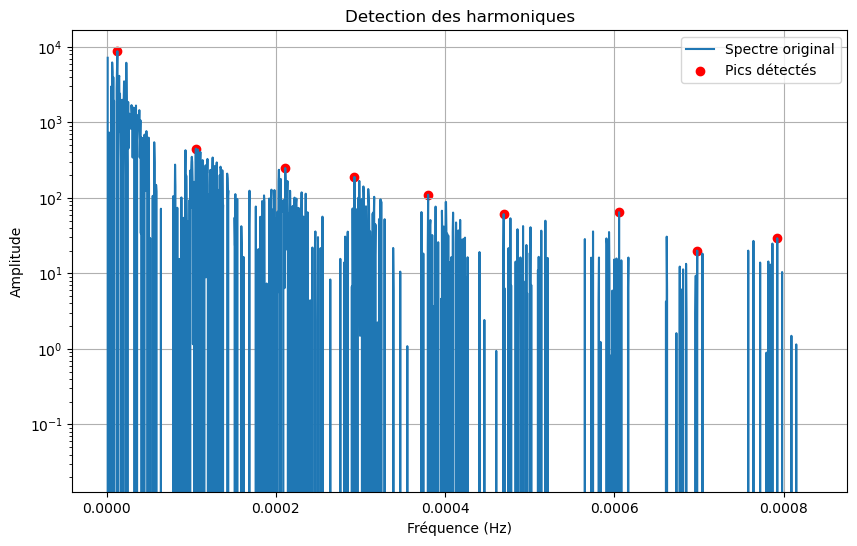

In [31]:
from scipy.signal import find_peaks

# Détection des pics
peaks, properties = find_peaks(amplitudes[:len(amplitudes)//2], height=0.1, distance=150)  # Ajuste les paramètres selon ton signal

# Récupération des fréquences et amplitudes des pics
peaks_frequencies = frequencies[peaks]
peaks_amplitudes = amplitudes[peaks]


print("Période ayant la plus grande amplitude", freq_to_day(peaks_frequencies[0]),"j")



# Affichage
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2], label='Spectre original')
plt.scatter(peaks_frequencies, peaks_amplitudes, color='red', label="Pics détectés")
plt.title("Detection des harmoniques")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

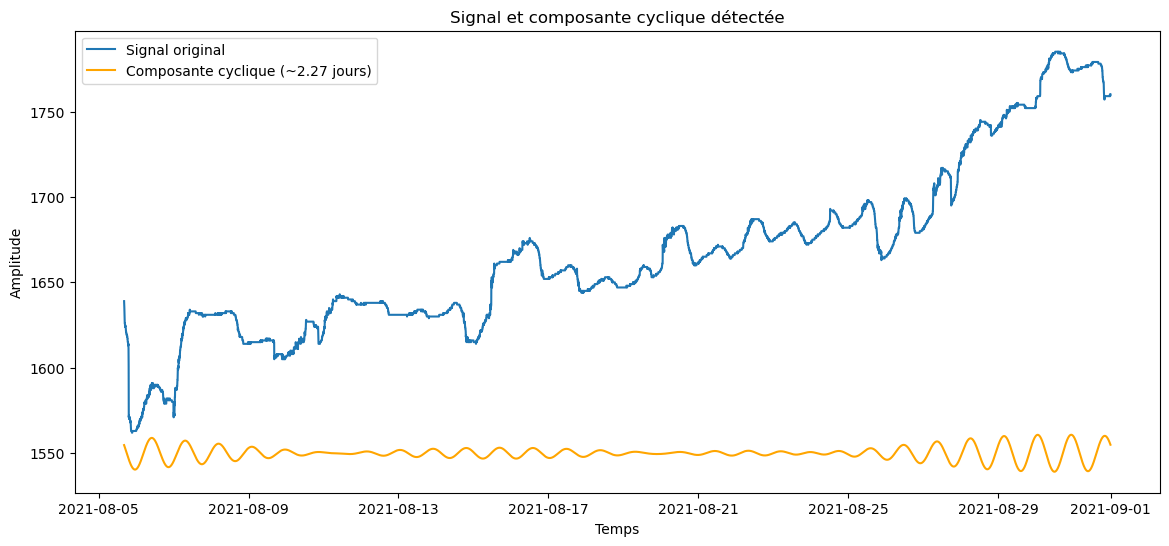

In [33]:
# Paramètres
T = 5*60  # Un point toutes les 5 min d'où 5*60
fs = 1 / T  
N = len(data_ajust) # Nombre de points
frequence_principale = peaks_frequencies[0]

# Filtrage autour de la fréquence dominante
largeur_bande = frequence_principale / 10  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequence_principale) < largeur_bande)

# Appliquer le filtre pour isoler la composante cyclique
signal_cyclique_fft = signal_fft * filtre_cyclique
signal_cyclique = np.fft.irfft(signal_cyclique_fft)

# Affichage du signal original et de sa composante cyclique
plt.figure(figsize=(14, 6))
plt.plot(datetime_data,data_ajust, label="Signal original")
plt.plot(datetime_data,signal_cyclique.real+1550, label=f"Composante cyclique (~{freq_to_day(frequence_principale):.2f} jours)", color="orange")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

## Densité spectrale Welch

In [35]:
from scipy.signal import welch

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Implémentation de la méthode de Welch
def welch_manual(data, fs, nperseg, noverlap=None):
    # Taille du signal
    n = len(data)
    
    # Calcul de l'overlap
    if noverlap is None:
        noverlap = nperseg // 2
    
    # Nombre de segments
    nsegments = (n - nperseg) // (nperseg - noverlap) + 1
    
    # Fréquences de la FFT
    freqs = np.fft.fftfreq(nperseg, d=1/fs)
    freqs = freqs[:nperseg//2]  # On ne garde que les fréquences positives
    
    # Densité spectrale de puissance
    psd = np.zeros(len(freqs))
    
    for i in range(nsegments):
        # Indices de début et de fin de chaque segment
        start = i * (nperseg - noverlap)
        end = start + nperseg
        
        # Segment du signal
        segment = data[start:end]
        
        # FFT du segment
        fft_segment = np.fft.fft(segment)
        
        # Calcul de la puissance (module au carré de la FFT)
        psd_segment = np.abs(fft_segment[:nperseg//2])**2
        
        # Moyenne des PSDs sur les segments
        psd += psd_segment
    
    psd /= nsegments  # Moyenne sur les segments
    
    return freqs, psd

/var/folders/gn/sy_p6gyd0s15vprgs70pb0dr0000gn/T/ipykernel_19212/303370147.py:40: RuntimeWarning: invalid value encountered in divide
  psd /= nsegments  # Moyenne sur les segments
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 8192 is greater than input length  = 7580, using nperseg = 7580
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


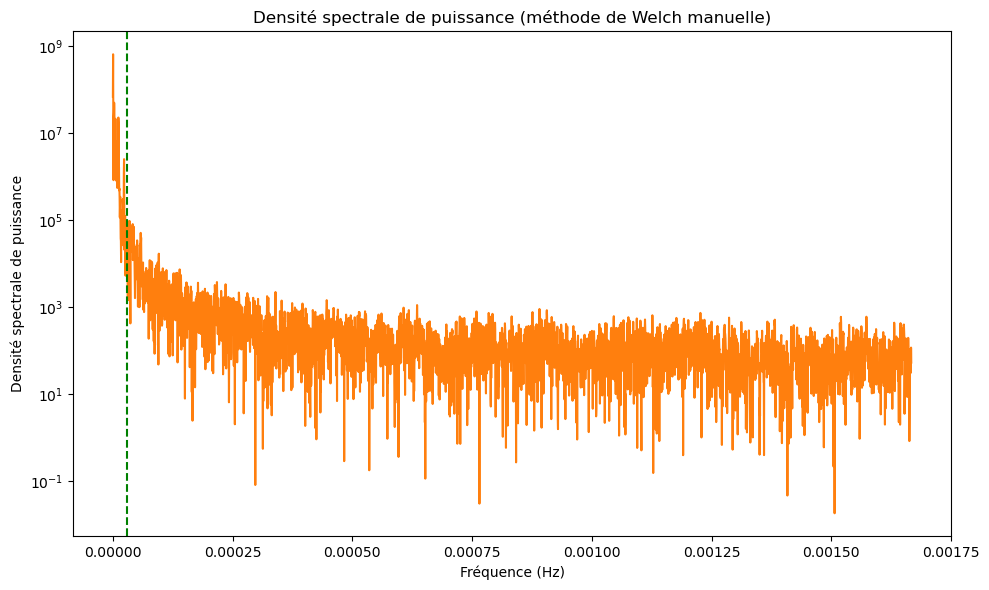

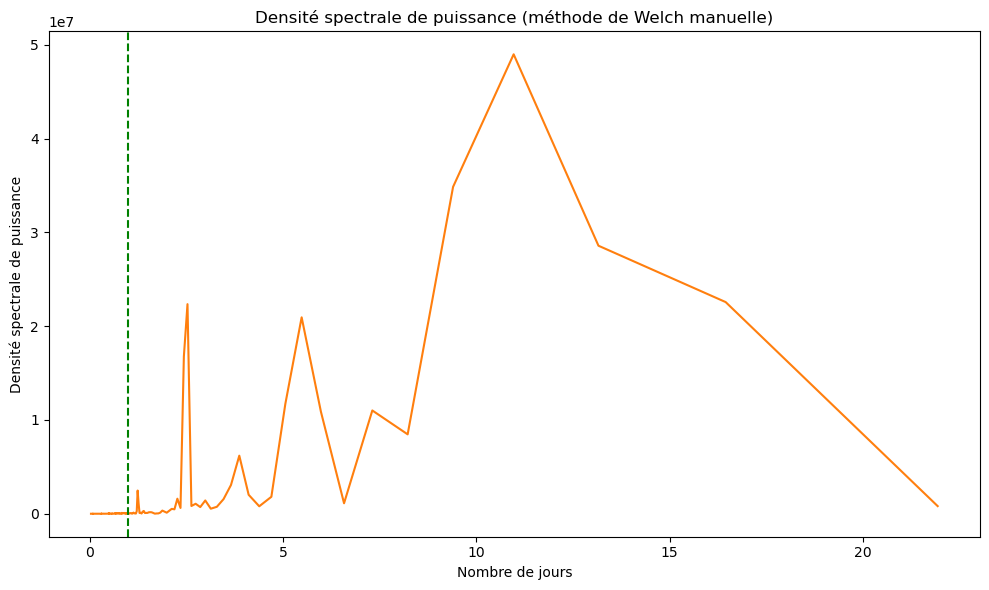

In [39]:
 #Paramètres de la méthode de Welch
nperseg = 8192 # 288
noverlap = int(nperseg/5)
fs = 1 / (60*5)

# Estimation de la PSD avec notre implémentation manuelle de Welch
frequencies_manual, psd_manual = welch_manual(data_ajust, fs, nperseg, noverlap)
frequencies_auto, psd_auto = welch(data_ajust, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")

# Tracé du résultat
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_manual, psd_manual)
plt.semilogy(frequencies_auto, np.abs(psd_auto))
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Cycle diurne')
plt.title('Densité spectrale de puissance (méthode de Welch manuelle)')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freq_to_day(frequencies_manual[3:len(frequencies_manual)//2]), psd_manual[3:len(psd_manual)//2])
plt.plot(freq_to_day(frequencies_auto[3:len(frequencies_auto)//2]), np.abs(psd_auto[3:len(psd_auto)//2]))
plt.axvline(x=1, color='green', linestyle='--',label='Cycle diurne')
plt.title('Densité spectrale de puissance (méthode de Welch manuelle)')
plt.xlabel('Nombre de jours')
plt.ylabel('Densité spectrale de puissance')
plt.tight_layout()
plt.show()


In [41]:
top_3_indices = np.argsort(np.abs(psd_auto))[-20:][::-1]

print(top_3_indices)

# Afficher les indices et les fréquences correspondantes
results = []
for i, index in enumerate(top_3_indices):
    max_psd_frequency_m = frequencies_auto[index]
    result = (1 / max_psd_frequency_m) / (60 * 60 * 24)  # Application de la formule
    results.append(result)
    print(f"Valeur #{i+1} : fréquence = {max_psd_frequency_m}, résultat = {result} jours")
##

max_psd_index_a = np.argmax(np.abs(psd_auto))
max_psd_frequency_a = frequencies_auto[max_psd_index_a]

max_psd_index_m = np.argmax(np.abs(psd_manual))
max_psd_frequency_m = frequencies_manual[max_psd_index_m+1]


# Afficher la fréquence avec la plus grande PSD
print(f"Fréquence avec la plus grande PSD en manuel : {(1/max_psd_frequency_m)/(60*60*24)} j")
print(f"Fréquence avec la plus grande PSD en auto : {(1/max_psd_frequency_a)/(60*60*24)} j")

[ 1  0  6  7  5  4 26 12 27  2 13  9 11  8 17 18 53 16 14 29]
Valeur #1 : fréquence = 4.3975373790677223e-07, résultat = 26.319444444444443 jours
Valeur #2 : fréquence = 0.0, résultat = inf jours
Valeur #3 : fréquence = 2.6385224274406333e-06, résultat = 4.386574074074074 jours
Valeur #4 : fréquence = 3.0782761653474056e-06, résultat = 3.759920634920635 jours
Valeur #5 : fréquence = 2.198768689533861e-06, résultat = 5.263888888888889 jours
Valeur #6 : fréquence = 1.759014951627089e-06, résultat = 6.579861111111111 jours
Valeur #7 : fréquence = 1.1433597185576078e-05, résultat = 1.0122863247863247 jours
Valeur #8 : fréquence = 5.2770448548812665e-06, résultat = 2.193287037037037 jours
Valeur #9 : fréquence = 1.187335092348285e-05, résultat = 0.9747942386831275 jours
Valeur #10 : fréquence = 8.795074758135445e-07, résultat = 13.159722222222221 jours
Valeur #11 : fréquence = 5.716798592788039e-06, résultat = 2.0245726495726495 jours
Valeur #12 : fréquence = 3.95778364116095e-06, résultat 

/var/folders/gn/sy_p6gyd0s15vprgs70pb0dr0000gn/T/ipykernel_19212/2262550883.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  result = (1 / max_psd_frequency_m) / (60 * 60 * 24)  # Application de la formule


Explication :

Il doit exister une composante cyclique au delà de notre domaine d'étude ( 1 an ? ). C'est pour cela qu'à chaque fois que l'on augmente nperseg, on affine notre précision spectrale, permettant d'attraper des fréquences plus petite ( donc des périodes plus longues). En fait la fréquence principales correspond à ce que Welch a pu comprendre de ce fameux cycle annuel ( d'où la plus grande fréquence possible à chaque fois). Ensuite si l'on affiche les autres fréquences importantes on voit qu'il y a les fréquences proches de la fréquences principales. Celles-ci ne sont pas représentatives mais on été artificiellement grossi par le spectral leakage. Cependant la prochaine fréquence intéressante qui apparait "d'elle même" est celle correspondant à 1j ( modulo les virgules du à la précision spectrale ). Cela confirme bien qu'une des composantes principales est le cycle diurne

Que l'on fasse Welch avec la fonction déjà implémentée ou Welch à la main, on trouve la même fréquence principale. Ce qui démontre la cohérence "sémantique". Toutefois le résultats obtenu n'est toujours pas celui attendu

# Série temporelle

### Modélisation avec la librairie STL

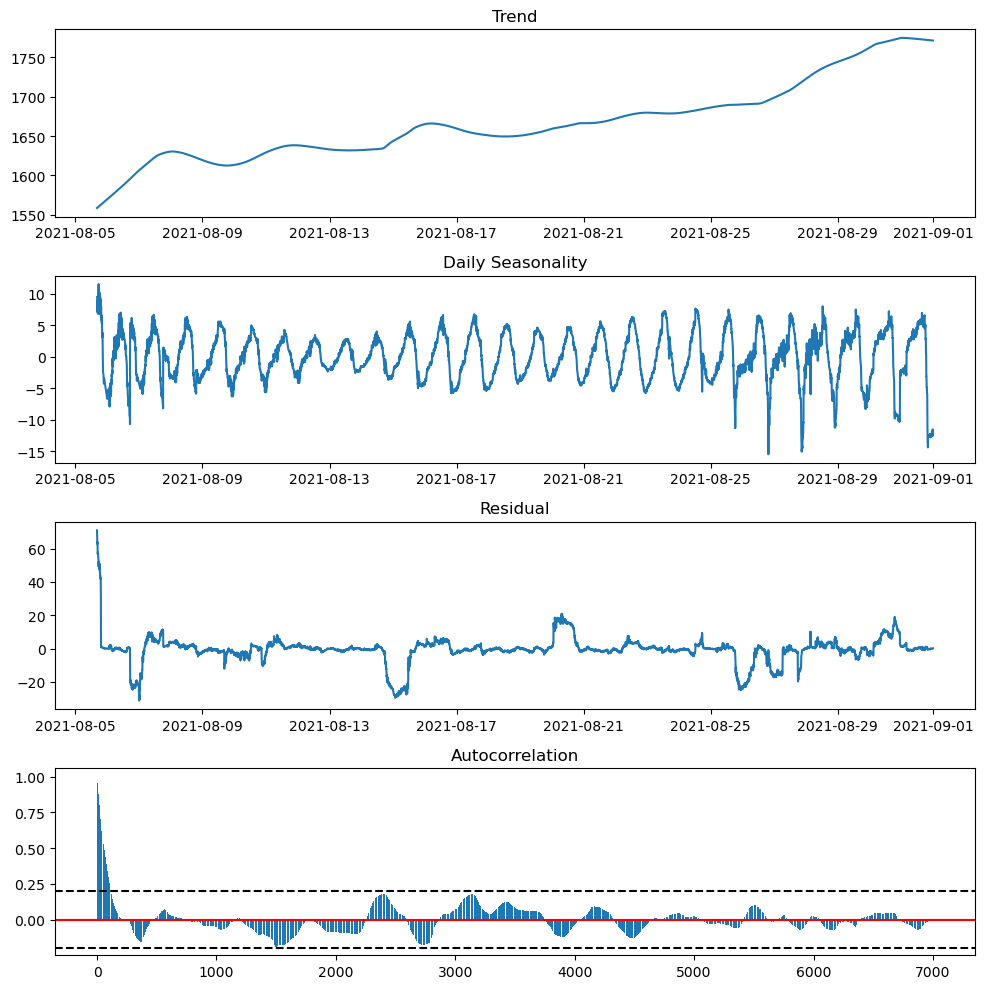

In [49]:
stl = STL(time_serie_crop, period=5*60, robust = True)
result = stl.fit()

max_lag = 7000
acf_values = sm.tsa.acf(result.resid, nlags = max_lag)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))
ax1.plot(datetime_data,result.trend)
ax1.set_title('Trend')
ax2.plot(datetime_data,result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(datetime_data,result.resid)
ax3.set_title('Residual')
ax4.bar(range(max_lag + 1), acf_values)
ax4.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
ax4.axhline(y=0, color='red', label='Ligne à x=0')
ax4.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
ax4.set_title("Autocorrelation")
plt.tight_layout()
plt.show()

In [46]:
# Analyse de la saisonalité

amplitudes = np.real(np.fft.rfft(result.seasonal))
frequencies = np.fft.rfftfreq(len(result.seasonal),5*60) 

peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 0.03)
frequence_principale = frequencies[peaks[0]] 
periode_principale = 1 / frequence_principale

print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 879.50748 1e-8 Hz, soit une période d'environ 1.32 jours


Les résidus ne présentent qu'un pic significatif au niveau de 0 : cela confirme que les résidus sont des bruits blancs

### Modélisation avec la librairie MSTL

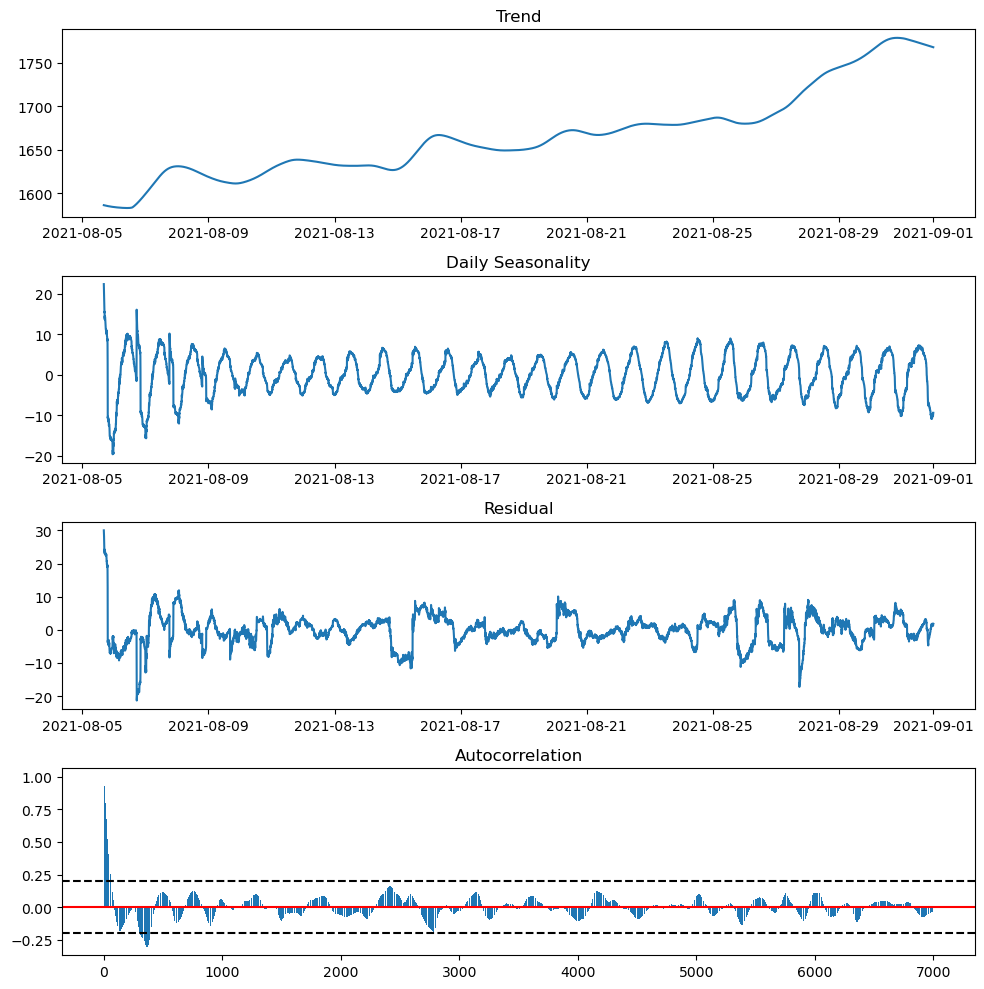

In [55]:
mstl = MSTL(time_serie_crop, periods=5*60)
result = mstl.fit()

max_lag = 7000
acf_values = sm.tsa.acf(result.resid, nlags = max_lag)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))
ax1.plot(datetime_data,result.trend)
ax1.set_title('Trend')
ax2.plot(datetime_data,result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(datetime_data,result.resid)
ax3.set_title('Residual')
ax4.bar(range(max_lag + 1), acf_values)
ax4.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
ax4.axhline(y=0, color='red', label='Ligne à x=0')
ax4.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
ax4.set_title("Autocorrelation")
plt.tight_layout()
plt.show()

In [56]:
# Analyse de la saisonalité

amplitudes = np.real(np.fft.rfft(result.seasonal))
frequencies = np.fft.rfftfreq(len(result.seasonal),5*60) 

peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 0.03)
frequence_principale = frequencies[peaks[0]] 
periode_principale = 1 / frequence_principale

print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 1231.31047 1e-8 Hz, soit une période d'environ 0.94 jours


Les résidus ne présentent qu'un pic significatif au niveau de 0 : cela confirme que les résidus sont des bruits blancs

### Modélisation avec seasonal_decompose

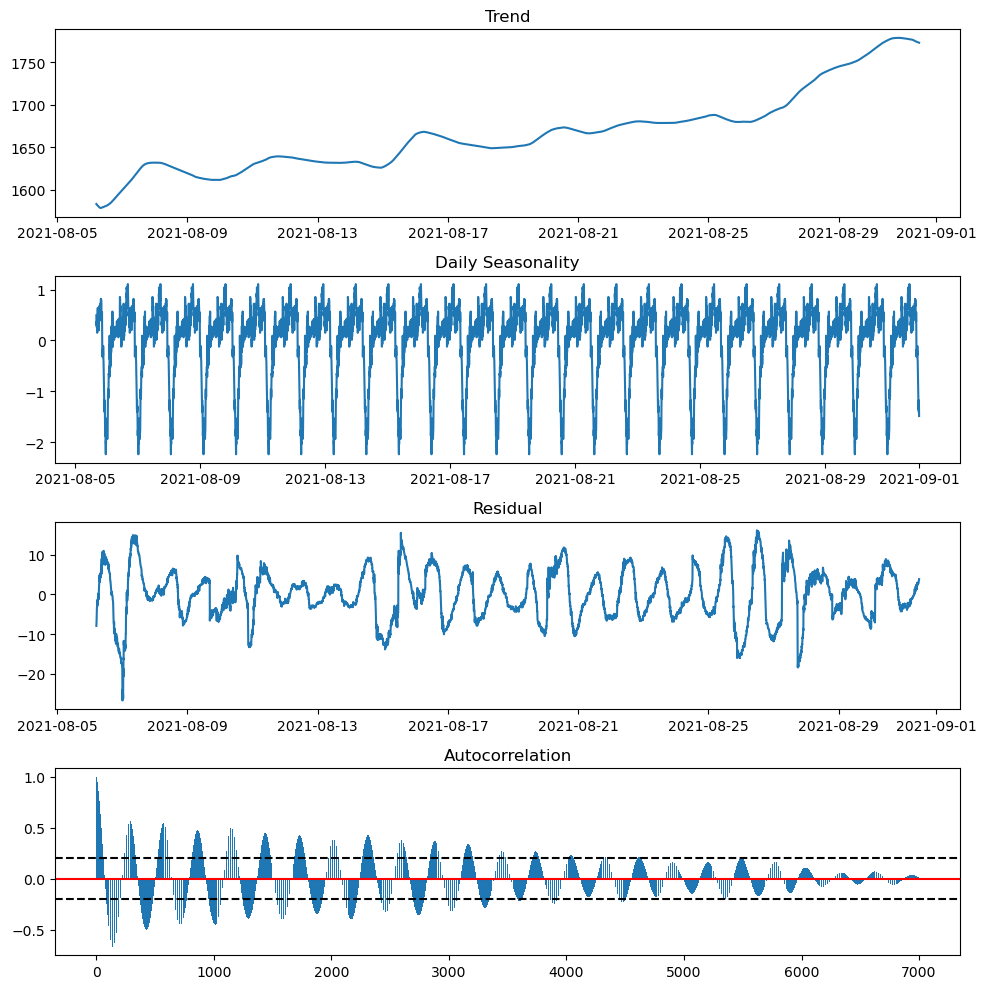

In [57]:
result = seasonal_decompose(time_serie_crop, model='additive', period=60*5)

max_lag = 7000
acf_values = sm.tsa.acf(result.resid, nlags = max_lag, missing="drop")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))
ax1.plot(datetime_data,result.trend)
ax1.set_title('Trend')
ax2.plot(datetime_data,result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(datetime_data,result.resid)
ax3.set_title('Residual')
ax4.bar(range(max_lag + 1), acf_values)
ax4.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
ax4.axhline(y=0, color='red', label='Ligne à x=0')
ax4.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
ax4.set_title("Autocorrelation")
plt.tight_layout()
plt.show()

In [60]:
# Analyse de la saisonalité

amplitudes = np.real(np.fft.rfft(result.seasonal))
frequencies = np.fft.rfftfreq(len(result.seasonal),5*60) 

peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 0.03)
frequence_principale = frequencies[peaks[0]] 
periode_principale = 1 / frequence_principale

print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 1143.35972 1e-8 Hz, soit une période d'environ 1.01 jours


### Moyennes mobiles

In [77]:
signal_fft = np.fft.rfft(data_ajust)
amplitudes = np.real(signal_fft)[3:] 
frequencies = np.fft.rfftfreq(len(data_ajust),5*60)[3:] 
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 0.03)
frequence_principale = frequencies[peaks[5]] 
periode_principale = 1 / frequence_principale

print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 879.50748 1e-8 Hz, soit une période d'environ 1.32 jours


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


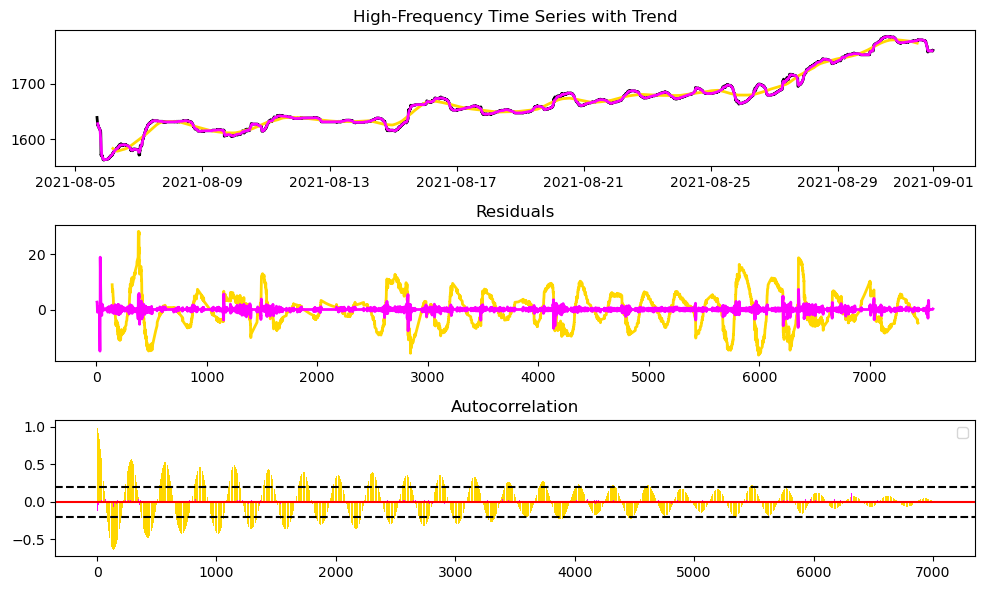

In [82]:
# Calculate rolling mean (adjust window to 96 for daily trends)
rolling_mean_d = time_serie_crop.rolling(window=24*12, center=True).mean()
rolling_mean_p = time_serie_crop.rolling(window=int(12*periode_principale/(3600*24)), center=True).mean()

# Calcul des résidus

daily = rolling_mean_d-time_serie_crop
princ = rolling_mean_p-time_serie_crop

# Calcul de l'autocorrélation
max_lag = 7000
acf_values_daily = sm.tsa.acf(daily.dropna(), nlags = max_lag)
acf_values_princ = sm.tsa.acf(princ.dropna(), nlags = max_lag)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

# Affichage des data
ax1.plot(datetime_data,time_serie_crop, label='Original Data', color='black', linewidth=2)
ax1.plot(datetime_data,rolling_mean_d, label='Trend journalière', color='gold', linewidth=2)
ax1.plot(datetime_data,rolling_mean_p, label='Trend de la fréquence principale', color='fuchsia', linewidth=2)
ax1.set_title('High-Frequency Time Series with Trend')
plt.legend()

# Affichage des résidus
ax2.plot(daily, label='daily', color='gold', linewidth=2)
ax2.plot(princ, label='princ', color='fuchsia', linewidth=2)
ax2.set_title('Residuals')

# Affichage de l'autocorrélation
ax3.bar(range(max_lag + 1), acf_values_daily, color='gold')
ax3.bar(range(max_lag + 1), acf_values_princ, color='fuchsia')
ax3.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
ax3.axhline(y=0, color='red', label='Ligne à x=0')
ax3.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
ax3.set_title("Autocorrelation")
plt.tight_layout()
plt.show()

### Modélisation à la main

#### Filtre passe-bas (Butterworth)

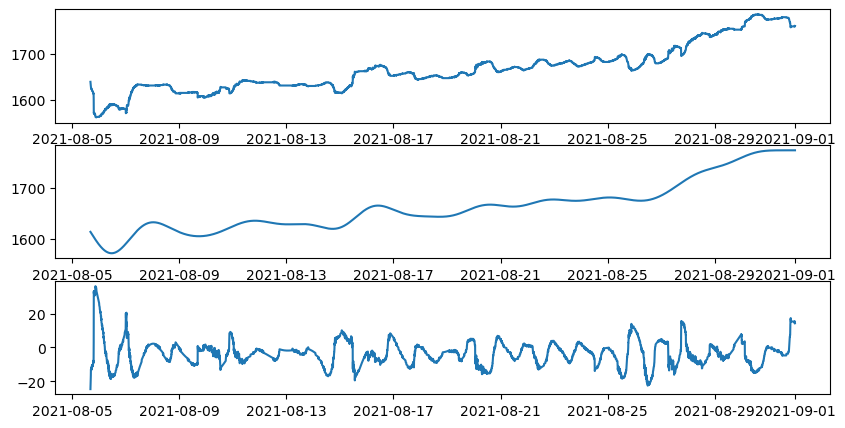

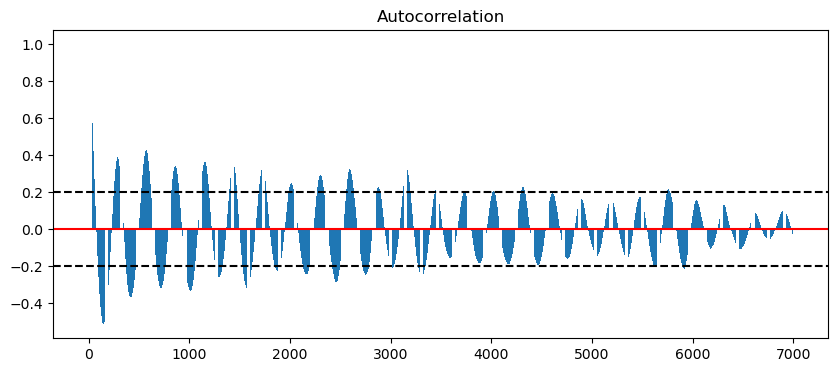

In [94]:
# Plot de la tendance à l'aide d'un filtre passe-bas
from scipy.signal import butter, filtfilt
import statsmodels.api as sm

# Paramètres du filtre
ordre = 6
frequence_coupure = 1/(60*5)

# Création du filtre passe-bas
b, a = butter(ordre, frequence_coupure, btype='low', analog=False)

# Application du filtre
data_filtre = filtfilt(b, a, data_ajust)

residus = data_filtre - data_ajust

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(datetime_data,data_ajust, label="Original signal")
plt.subplot(3, 1, 2)
plt.plot(datetime_data,data_filtre, label="Filtered signal")
plt.subplot(3, 1, 3)
plt.plot(datetime_data,residus, label="Residuals")
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 7000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.title("Autocorrelation")
plt.show()

Les résidus présentent 2 pics significatifs : pas de bruits blancs

#### Filtre passe-bas (Savitzky-Golay)

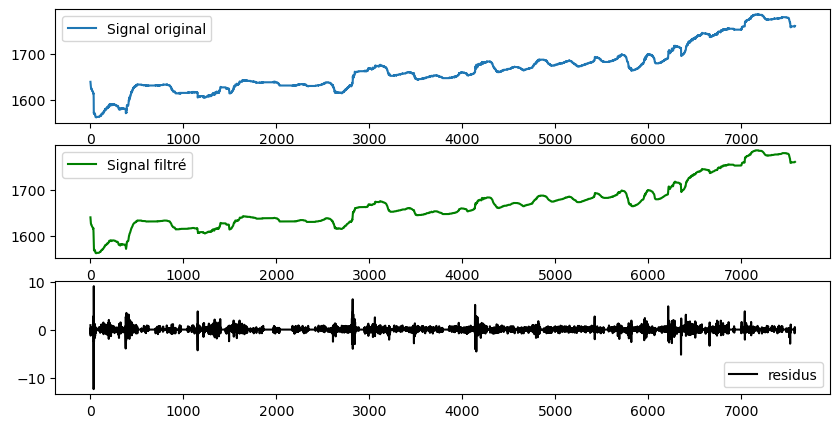

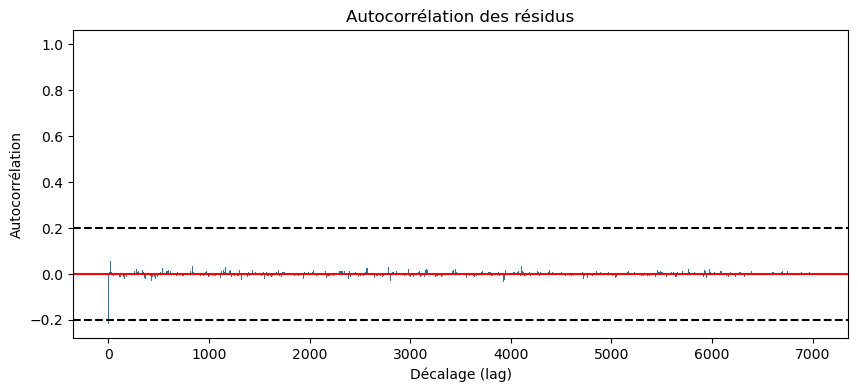

In [96]:
# Plot de la tendance à l'aide d'un filtre passe-bas
from scipy.signal import savgol_filter, filtfilt
import statsmodels.api as sm

# Paramètres du filtre
ordre = 5
frequence_coupure = 1/(60*5)

# Création du filtre passe-bas
data_filtre = savgol_filter(data_ajust,10,2)

residus = data_filtre - data_ajust

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 7000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

Les résidus présentent 2 pics significatifs : pas de bruits blancs

#### Lissage exponentiel

In [97]:
import numpy as np

def lissage_exponentiel(data, alpha):
    """
    Applique un lissage exponentiel à une série de données.

    :param data: Liste ou array des données brutes.
    :param alpha: Coefficient de lissage (0 < alpha ≤ 1).
    :return: Array des valeurs lissées.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Le coefficient alpha doit être compris entre 0 et 1.")
    
    # Initialisation de la liste des valeurs lissées
    lissage = np.zeros_like(data, dtype=float)
    lissage[0] = data[0]  # La première valeur lissée est identique à la première donnée brute

    # Application du lissage exponentiel
    for t in range(1, len(data)):
        lissage[t] = alpha * data[t] + (1 - alpha) * lissage[t-1]
    
    return lissage


<Figure size 1200x600 with 0 Axes>

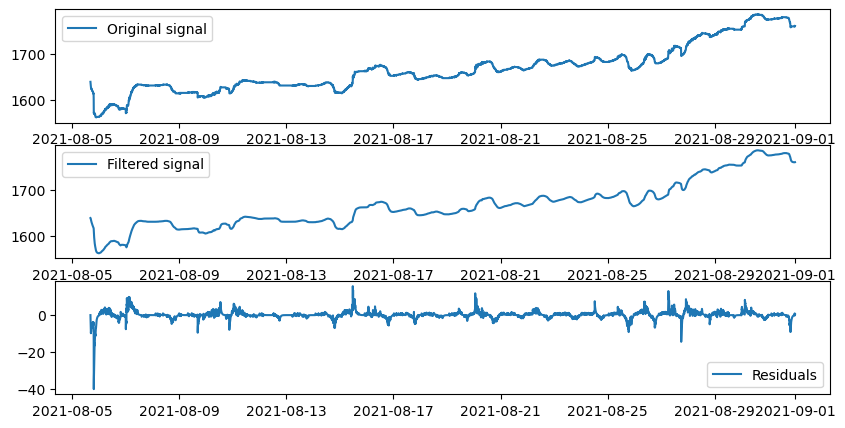

<Figure size 640x480 with 0 Axes>

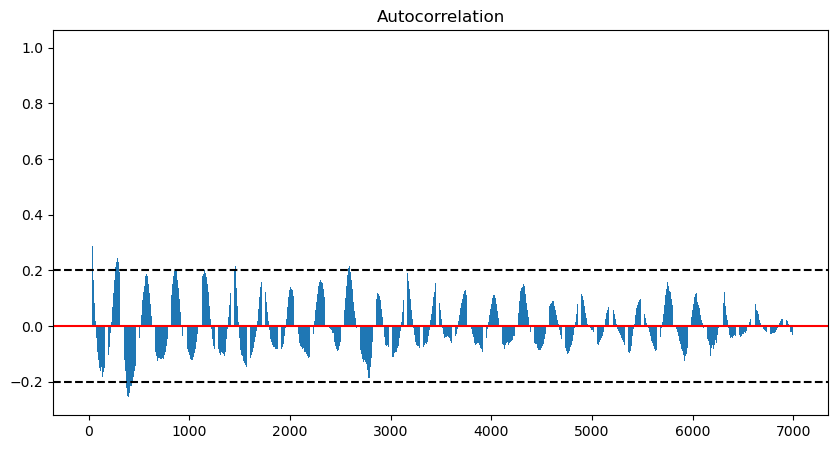

In [102]:
# Calcul des données lissées et des résidus
alpha=0.1
lissage_resultat = lissage_exponentiel(data_ajust, alpha)
residus = data_ajust - lissage_resultat

# Tracé des résultats
plt.figure(figsize=(12, 6))

# Graphique des données brutes et lissées
# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(datetime_data,data_ajust, label="Original signal")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(datetime_data, lissage_resultat, label="Filtered signal")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(datetime_data, residus, label="Residuals")
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 7000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 5))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.title("Autocorrelation")
plt.show()

Les résidus ne présentent qu'un pics significatifs en 0 : bruit blanc